In [1]:
## Q2 ##
#part 2#
# drag effect on orbital elements #

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.integrate import ode
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy.optimize import basinhopping
from scipy.optimize import brute
from scipy.optimize import fmin
from scipy.optimize import fminbound
from scipy.spatial.transform import Rotation

import time
import math
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
# orbital elements #
a = 6783.34174
e = 0.0014021
i = 51.27632*np.pi/180 # rad
omega = 90.69731*np.pi/180 # rad
Omega = 275.17058*np.pi/180 # rad
theta = 309.67626*np.pi/180 # rad

# calculate other needed parameter #
mu = 398600.4415 # km^3/s^2
R_e = 6378.1363 # km
J2 = 0.0010826269
n = np.sqrt(mu/a**3) # rad/s
h = np.sqrt(mu*a*(1-e**2)) # km^2/s
p = a*(1-e**2) # km
r = p/(1+e*np.cos(theta)) # km



In [3]:
## funcrions in RSW ##
def da_dt(F_R, F_S, elements):
    a = elements[0]
    e = elements[1]
    i = elements[2]
    omega = elements[3]
    Omega = elements[4]
    theta = elements[5]
    n = np.sqrt(mu/a**3) # rad/s
    h = np.sqrt(mu*a*(1-e**2)) # km^2/s
    p = a*(1-e**2) # km
    r = p/(1+e*np.cos(theta)) # km
    return 2/(n*np.sqrt(1-e**2))*(e*np.sin(theta) * F_R + p/r *F_S)

def de_dt(F_R, F_S, elements):
    a = elements[0]
    e = elements[1]
    i = elements[2]
    omega = elements[3]
    Omega = elements[4]
    theta = elements[5]
    n = np.sqrt(mu/a**3) # rad/s
    h = np.sqrt(mu*a*(1-e**2)) # km^2/s
    p = a*(1-e**2) # km
    r = p/(1+e*np.cos(theta)) # km
    return np.sqrt(1-e**2)/(n*a)*(np.sin(theta)*F_R + (np.cos(theta) + (e+np.cos(theta))/(1+e*np.cos(theta)))*F_S)


def di_dt(F_W, elements):
    a = elements[0]
    e = elements[1]
    i = elements[2]
    omega = elements[3]
    Omega = elements[4]
    theta = elements[5]
    n = np.sqrt(mu/a**3) # rad/s
    h = np.sqrt(mu*a*(1-e**2)) # km^2/s
    p = a*(1-e**2) # km
    r = p/(1+e*np.cos(theta)) # km
    u = omega + theta
    return r*np.cos(u)/(n*a**2*np.sqrt(1-e**2))*F_W

def dOmega_dt(F_W, elements):
    a = elements[0]
    e = elements[1]
    i = elements[2]
    omega = elements[3]
    Omega = elements[4]
    theta = elements[5]
    n = np.sqrt(mu/a**3) # rad/s
    h = np.sqrt(mu*a*(1-e**2)) # km^2/s
    p = a*(1-e**2) # km
    r = p/(1+e*np.cos(theta)) # km
    return r*np.sin(theta)/(n*a**2*np.sqrt(1-e**2)*np.sin(i))*F_W

def domega_dt(F_R, F_S, F_W, elements):
    a = elements[0]
    e = elements[1]
    i = elements[2]
    omega = elements[3]
    Omega = elements[4]
    theta = elements[5]
    n = np.sqrt(mu/a**3) # rad/s
    h = np.sqrt(mu*a*(1-e**2)) # km^2/s
    p = a*(1-e**2) # km
    r = p/(1+e*np.cos(theta)) # km
    u = omega + theta
    return np.sqrt(1-e**2)/(n*a*e)*(-np.cos(theta)*F_R + np.sin(omega)*(1+1/p)*F_S) - r*np.cos(i)*np.sin(u)/h*F_W

def dtheta_dt(F_R, F_S, elements):
    a = elements[0]
    e = elements[1]
    i = elements[2]
    omega = elements[3]
    Omega = elements[4]
    theta = elements[5]
    n = np.sqrt(mu/a**3) # rad/s
    h = np.sqrt(mu*a*(1-e**2)) # km^2/s
    p = a*(1-e**2) # km
    r = p/(1+e*np.cos(theta)) # km
    return h/r**2 + 1/(e*h)*(p*np.cos(theta)*F_R - (p+r)*np.sin(theta)*F_S)

In [8]:
# calculate drag perturbation forces #
# force in s direction #
def F_S_drag(v, rho, s, C_D, m_s):
    return -1/(2*m_s) * rho * v**2 * s * C_D

def orbital_element2v(h, mu, e, nu, omega, Omega):
    r_w = h ** 2 / mu / (1 + e * np.cos(nu)) * np.array((np.cos(nu), np.sin(nu), 0))
    v_w = mu / h * np.array((-np.sin(nu), e + np.cos(nu), 0))

    R = Rotation.from_euler("ZXZ", [-omega, -i, -Omega])
    v_rot = v_w @ R.as_matrix()

    return np.linalg.norm(v_rot)


In [9]:
## calculate changes in orbital elements for 10 period ##
# initial values #
a0 = a
e0 = e  
i0 = i
omega0 = omega
Omega0 = Omega
theta0 = theta
rho = 1.51e-12
s = 1.25
C_D = 2.2
m_s = 250
elements0 = [a0, e0, i0, omega0, Omega0, theta0]
v = orbital_element2v(h, mu, e, theta, omega, Omega)

# initial forces #
F_R0 = 0
F_S0 = F_S_drag(v, rho, s, C_D, m_s)
F_W0 = 0

# prepare function for integral #
def d_elements(t, elements_function):
    a = elements_function[0]
    e = elements_function[1]
    i = elements_function[2]
    omega = elements_function[3]
    Omega = elements_function[4]
    theta = elements_function[5]
    
    r = p/(1+e*np.cos(theta))
    u = omega + theta
    v = orbital_element2v(h, mu, e, theta, omega, Omega)
    F_R = 0
    F_S = F_S_drag(v, rho, s, C_D, m_s)
    F_W = 0
    
    da = da_dt(F_R, F_S, elements_function)
    de = de_dt(F_R, F_S, elements_function)
    di = di_dt(F_W, elements_function)
    dOmega = dOmega_dt(F_W, elements_function)
    domega = domega_dt(F_R, F_S, F_W, elements_function)
    dtheta = dtheta_dt(F_R, F_S, elements_function)

    # if e < 0:
    #     e = 0
    #     de = 0
    
    return [da, de, di, dOmega, domega, dtheta]


In [10]:
# integerate with ode4 long time #
t_0 = 0
t_f = 5000
t_points = np.linspace(t_0, t_f, 10000)
sol = solve_ivp(d_elements, [t_0, t_f], elements0, t_eval=t_points)
sol.y[1][sol.y[1] < 0] = 0

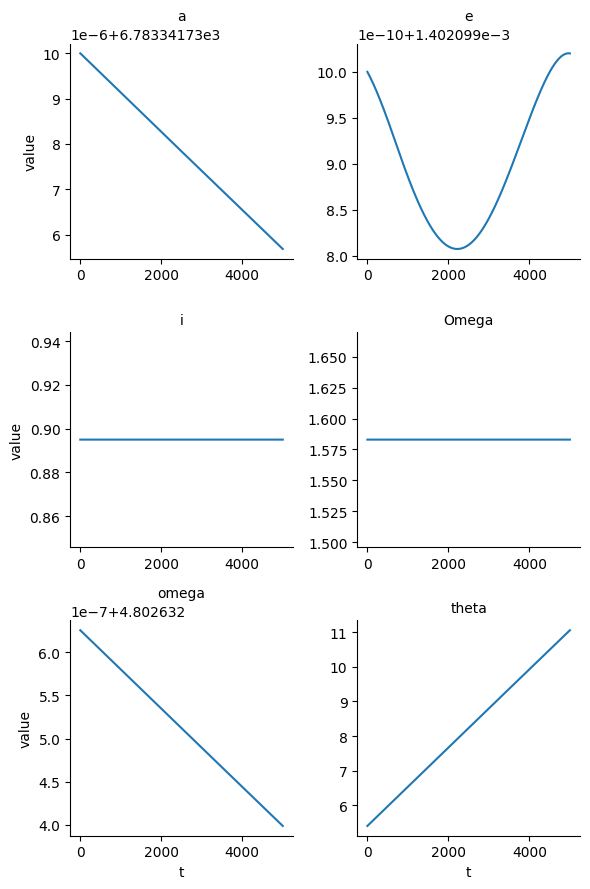

In [11]:
# plot results with seaborn #
df = pd.DataFrame(sol.y.T, columns=['a', 'e', 'i', 'Omega', 'omega', 'theta'])
df['t'] = sol.t
df = pd.melt(df, id_vars=['t'], value_vars=['a', 'e', 'i', 'Omega', 'omega', 'theta'])
g = sns.FacetGrid(df, col='variable', col_wrap=2, sharex=False, sharey=False)
g.map(plt.plot, 't', 'value')
g.set_titles('{col_name}')
g.set_xlabels('t')
g.set_ylabels('value')

# save fig as eps #
plt.savefig('../../Figure/Q2/orbital_elements_drag_5000.eps', format='eps', dpi=1000)

In [12]:
# integerate with ode4 long time #
t_0 = 0
t_f = 100
t_points = np.linspace(t_0, t_f, 10000)
sol = solve_ivp(d_elements, [t_0, t_f], elements0, t_eval=t_points)
sol.y[1][sol.y[1] < 0] = 0

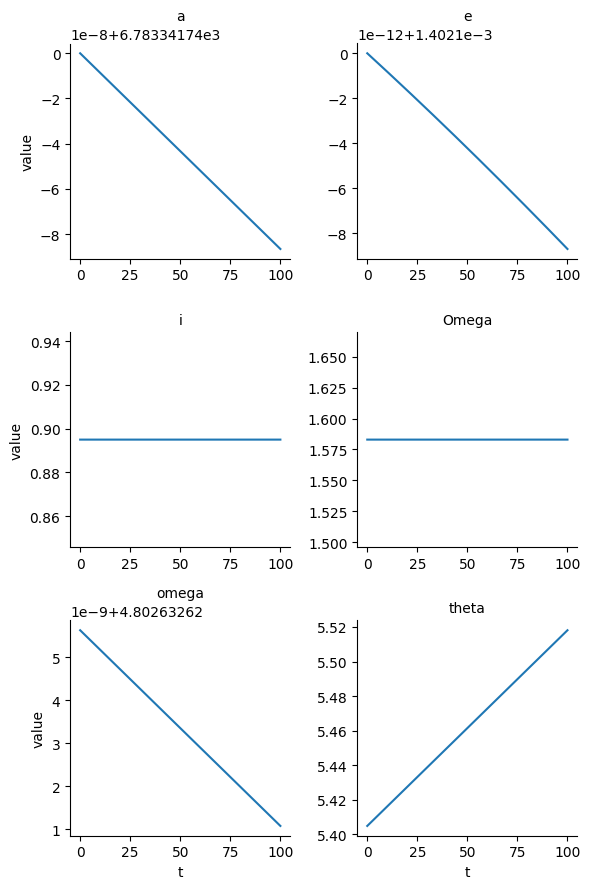

In [13]:
# plot results with seaborn #
df = pd.DataFrame(sol.y.T, columns=['a', 'e', 'i', 'Omega', 'omega', 'theta'])
df['t'] = sol.t
df = pd.melt(df, id_vars=['t'], value_vars=['a', 'e', 'i', 'Omega', 'omega', 'theta'])
g = sns.FacetGrid(df, col='variable', col_wrap=2, sharex=False, sharey=False)
g.map(plt.plot, 't', 'value')
g.set_titles('{col_name}')
g.set_xlabels('t')
g.set_ylabels('value')

# save fig as eps #
plt.savefig('../../Figure/Q2/orbital_elements_drag_100.eps', format='eps', dpi=1000)

In [14]:
# integerate with ode4 long time #
t_0 = 0
t_f = 100000
t_points = np.linspace(t_0, t_f, 10000)
sol = solve_ivp(d_elements, [t_0, t_f], elements0, t_eval=t_points)
sol.y[1][sol.y[1] < 0] = 0

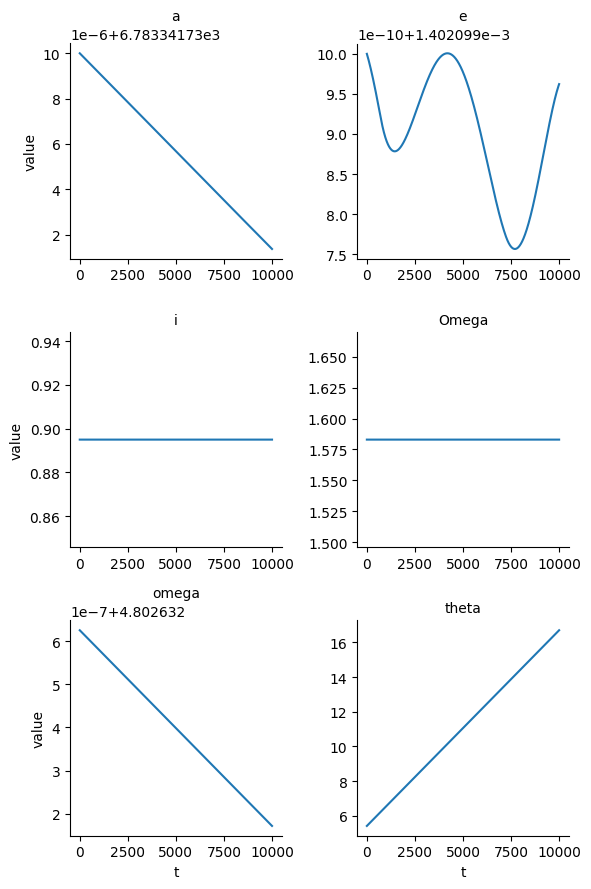

In [15]:
# plot results with seaborn #
df = pd.DataFrame(sol.y.T, columns=['a', 'e', 'i', 'Omega', 'omega', 'theta'])
df['t'] = sol.t
df = pd.melt(df, id_vars=['t'], value_vars=['a', 'e', 'i', 'Omega', 'omega', 'theta'])
g = sns.FacetGrid(df, col='variable', col_wrap=2, sharex=False, sharey=False)
g.map(plt.plot, 't', 'value')
g.set_titles('{col_name}')
g.set_xlabels('t')
g.set_ylabels('value')

# save fig as eps #
plt.savefig('../../Figure/Q2/orbital_elements_drag_100000.eps', format='eps', dpi=1000)